# 01 / Данные

*Summary*:

-  Используем внутридневные рыночные данные по ценам и объёмам торгов из [открытых источников](https://www.alphavantage.co/documentation/ 'API Documentation | Alpha Vantage')

-  Убираем нестационарность временных рядов (например, с помощью дифферинцирования)

-  Собираем трансофрмированные признаки в общий контейнер

-  На его основе готовим признаки-скользящие окна, которые будут использоваться при обучении

-  Разделяем на обучающую и тестовую выборки. К данным применяем масштабирование (фитим только на обучающей выборке, к тестовой применяем).

- Признаки - скользящие окна выбранного размера по временным рядам

In [1]:
import os, sys

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from pandas_datareader import data as pdr

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
import importlib

import mdp

importlib.reload(mdp)
importlib.reload(mdp.marketData)
importlib.reload(mdp.timeSeries)
importlib.reload(mdp.movingWindowFeatures)
importlib.reload(mdp.plotHelpers)
importlib.reload(mdp.utils);

In [5]:
from mdp import TimeSeries
from mdp import MarketData
from mdp import MovingWindowFeatures

import mdp.utils as utils
import mdp.plotHelpers as plotHelpers

# Параметры

In [6]:
INSTRUMENT = 'MSFT' # Microsoft corp
START_FROM = np.datetime64('today') - 7
WINDOW_SIZE = 120
FORECAST_OFFSET=1

# Рыночные данные

Загружаем открытые рыночные данные через [`pandas_datareader`](https://pandas-datareader.readthedocs.io/en/latest/index.html "pandas-datareader &mdash; pandas-datareader documentation") из сервиса [Alpha Vantage](https://www.alphavantage.co "Alpha Vantage - Free APIs for Realtime and Historical Stock, Forex (FX), Cryptocurrency Data, Technical Analysis, Charting, and More!") (в данном случае используем уже загруженные данные за предпоследнюю неделю марта 2020 г.).

In [7]:
instr_df = pdr.get_data_alphavantage(INSTRUMENT, function='TIME_SERIES_INTRADAY',
                                     api_key=os.environ.get('ALPHAVANTAGE_API_KEY'), start=START_FROM)

# instr_df = pd.read_csv('CVX_1min_2020-03-23_2020-03-27.csv', index_col='time')

instr_df

,open,high,low,close,volume
2020-04-08 09:31:00,165.6700,166.6000,165.40,166.3000,1092311
2020-04-08 09:32:00,166.2584,166.5700,165.90,166.1200,174917
2020-04-08 09:33:00,166.0901,166.6400,165.90,166.6150,210193
2020-04-08 09:34:00,166.1910,166.1910,166.15,166.1500,177975
2020-04-08 09:35:00,166.0500,166.0500,166.05,166.0500,142261
...,...,...,...,...,...
2020-04-14 15:56:00,173.5200,173.5700,173.30,173.4950,212908
2020-04-14 15:57:00,173.4900,173.5400,173.37,173.5100,179175
2020-04-14 15:58:00,173.5300,173.6001,173.44,173.4941,197704
2020-04-14 15:59:00,173.4950,173.5400,173.28,173.4800,257937


In [8]:
instr_df.info();

<class 'pandas.core.frame.DataFrame'>
Index: 1556 entries, 2020-04-08 09:31:00 to 2020-04-14 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1556 non-null   float64
 1   high    1556 non-null   float64
 2   low     1556 non-null   float64
 3   close   1556 non-null   float64
 4   volume  1556 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 72.9+ KB


In [9]:
dates_unique = np.unique(instr_df.index.values.astype('datetime64[D]'))

START_FROM = dates_unique[0]
VAL_TEST_SPLIT = dates_unique[-1]

START_FROM, VAL_TEST_SPLIT

(numpy.datetime64('2020-04-08'), numpy.datetime64('2020-04-14'))

Сохраняем данные и вычисляем индикаторы.

In [10]:
instr = MarketData.create_from_alphavantage_intraday(INSTRUMENT, start=START_FROM)

Наши признаки: цены (открытие, максимум, минимум, закрытие), объём торгов, индикаторы.

In [11]:
instr.feature_names

['o',
 'h',
 'l',
 'c',
 'v',
 'ema14',
 'ema30',
 'macd',
 'macd_signal',
 'rsi14',
 'bband20_upper',
 'bband20_middle',
 'bband20_lower',
 'willr14',
 'stochk',
 'stochd',
 'adline',
 'adosc']

# Исходные признаки

И проверка их стационарности.

## Цены

### Цена закрытия

Скорректированная (adjusted) на корпоративные действия.
Наш основной признак и целевая переменная.

Сам ряд цен, нестационарен:

In [12]:
instr.c.adf_report(True)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic         0.106698
P-Value                    0.966515
# Lags Used                0.000000
# Observations Used     1522.000000
Critical Value (1%)       -3.434654
Critical Value (5%)       -2.863441
Critical Value (10%)      -2.567782
dtype: float64


(0.9665154282021021, False)

Переходим к логарифмическим доходностям. Уже это позволяет сделать ряд стациоарным:

In [13]:
close_log_returns = instr.c.transform(transforms={'ratios' : {}, 'ln' : {}})

close_log_returns.adf_report(True)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -39.970458
P-Value                    0.000000
# Lags Used                0.000000
# Observations Used     1521.000000
Critical Value (1%)       -3.434657
Critical Value (5%)       -2.863442
Critical Value (10%)      -2.567783
dtype: float64


(0.0, True)

#### Визуализация

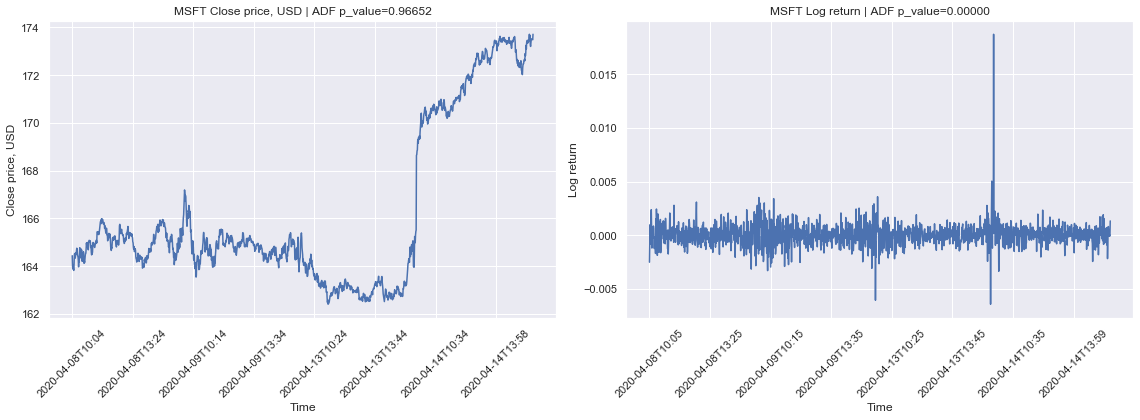

In [14]:
plotHelpers.plot_transformed_timeseries_unit(instr, close_log_returns, 'Close price, USD', 'Log return',
                                             datetime_unit='m', rotation=45)

### Цена открытия

Аналогично для цены открытия.

In [15]:
instr.o.adf_report()

(0.9729370385551431, False)

In [16]:
instr.o.transform(transforms={'ratios' : {}, 'ln' : {}}).adf_report()

(6.24727709785604e-26, True)

### Максимальная цена дня

In [17]:
instr.h.adf_report()

(0.9704368582219509, False)

In [18]:
instr.h.transform(transforms={'ratios' : {}, 'ln' : {}}).adf_report()

(7.688945603747562e-21, True)

### Минмальная цена дня

In [19]:
instr.l.adf_report()

(0.9549512248748613, False)

In [20]:
instr.l.transform(transforms={'ratios' : {}, 'ln' : {}}).adf_report()

(1.217727602740604e-13, True)

## Объём торгов

По критерию ADF он сразу оказался стационарным, хотя есть очевидные выбросы.

In [21]:
instr.v.adf_report()

(1.1789133710468575e-05, True)

После дифференцирования:

In [22]:
diff_order = 1

volume_diff =  instr.v.transform(transforms={'diffs': {'order': diff_order}})

volume_diff.adf_report(False)

(6.483267667570894e-29, True)

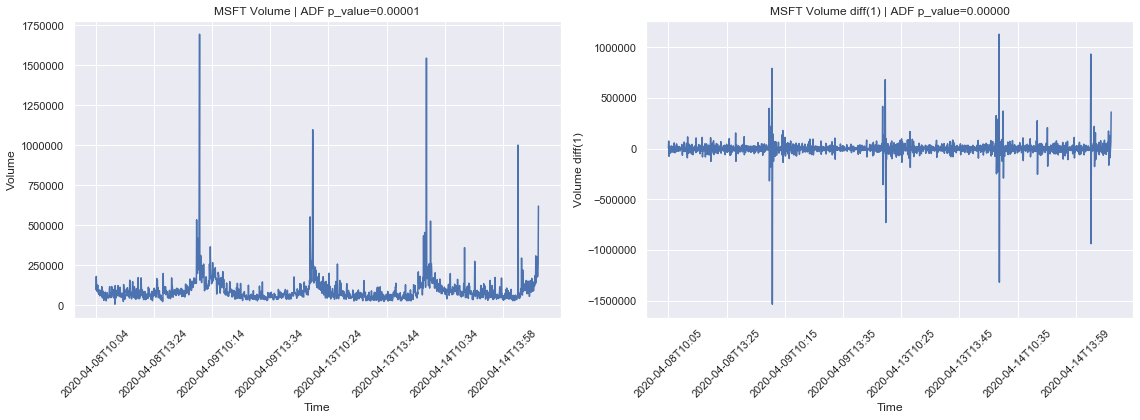

In [23]:
plotHelpers.plot_transformed_timeseries_unit(instr, volume_diff, 'Volume', f'Volume diff({diff_order})',
                                             datetime_unit='m', rotation=45)

## Индикаторы

### [MACD](https://www.investopedia.com/terms/m/macd.asp)

#### Визуализация

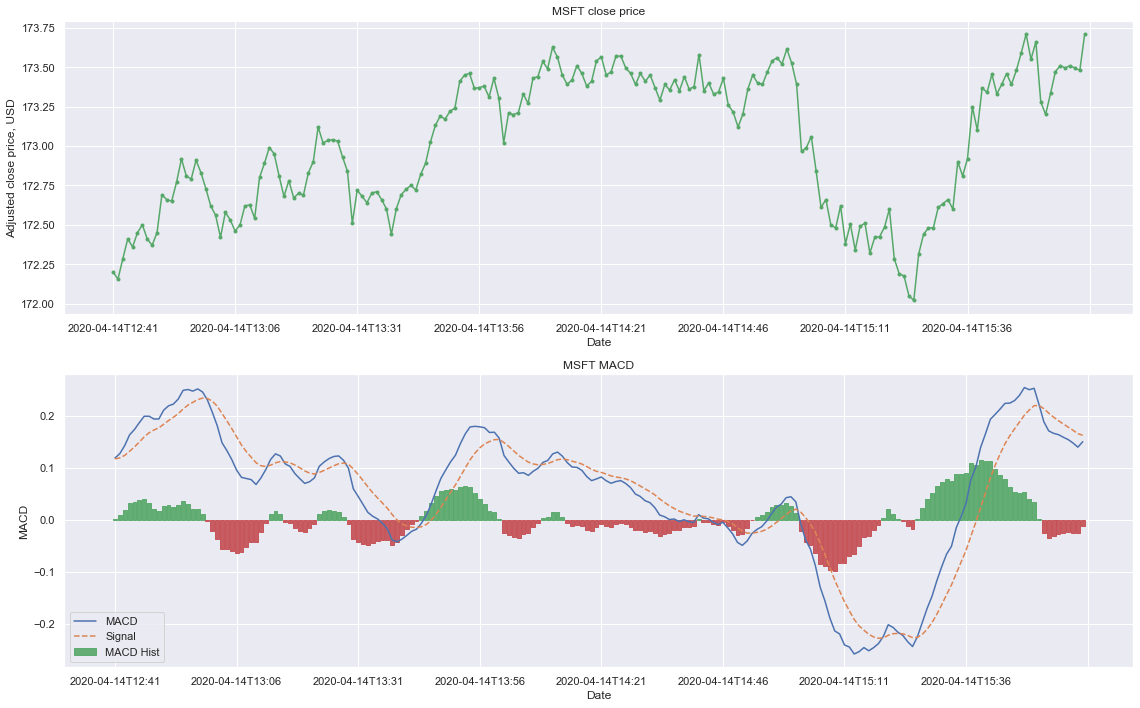

In [24]:
plotHelpers.plot_macd(instr, 200, datetime_unit='m')

#### MACD

MACD по критерию ADF также сразу определяется как стационарный.

In [25]:
instr.macd.adf_report()

(2.396809951256227e-07, True)

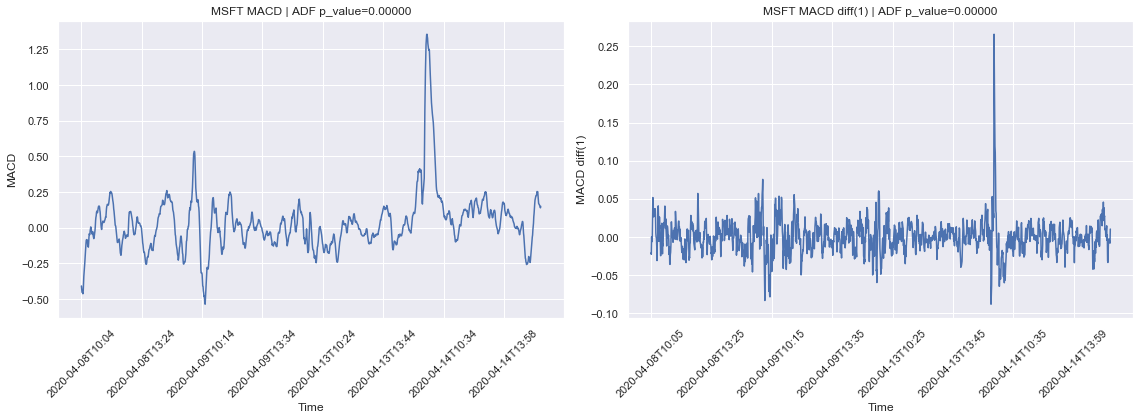

In [26]:
diff_order = 1

plotHelpers.plot_transformed_timeseries_unit(instr,
                        instr.macd.transform(transforms={'diffs': {'order': diff_order}}),
                        'MACD', f'MACD diff({diff_order})',
                        datetime_unit='m', rotation=45)

### [EMA](https://www.investopedia.com/terms/e/ema.asp)

In [27]:
instr.ema14.adf_report()

(0.9664522710200231, False)

In [28]:
diff_order = 1

ema14_diff = instr.ema14.transform(transforms={'diffs' : {'order' : diff_order}})

ema14_diff.adf_report()

(8.25021068929969e-19, True)

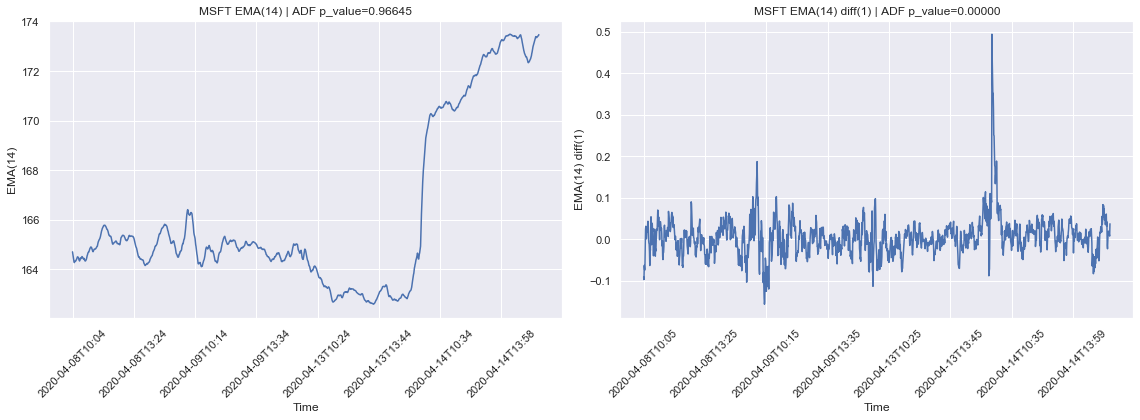

In [29]:
plotHelpers.plot_transformed_timeseries_unit(instr,
                        ema14_diff,
                        'EMA(14)', f'EMA(14) diff({diff_order})',
                        datetime_unit='m', rotation=45)

### [RSI](https://www.investopedia.com/terms/r/rsi.asp)

In [30]:
instr.rsi14.adf_report()

(2.1748756181879859e-13, True)

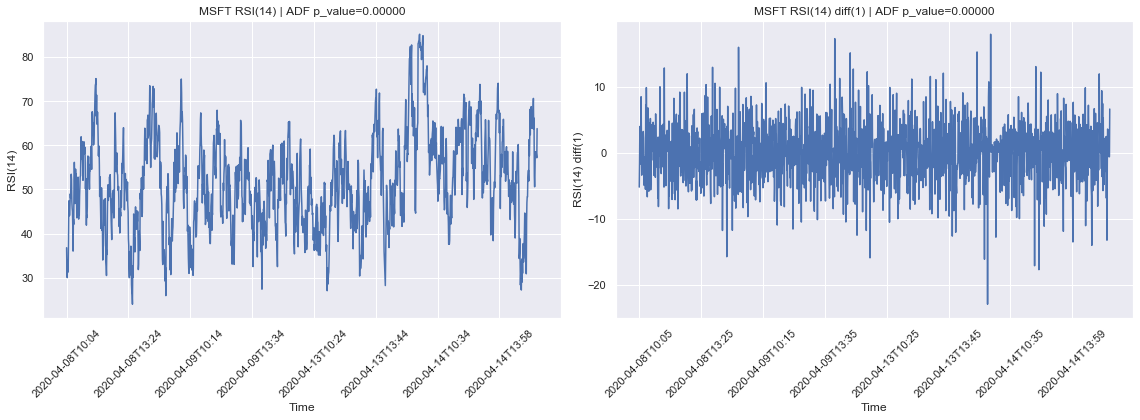

In [31]:
diff_order = 1

plotHelpers.plot_transformed_timeseries_unit(instr,
                        instr.rsi14.transform(transforms={'diffs' : {'order' : diff_order}}),
                        'RSI(14)', f'RSI(14) diff({diff_order})',
                        datetime_unit='m', rotation=45)

### [Bollinger Band](https://www.investopedia.com/terms/b/bollingerbands.asp)

In [32]:
instr.bband20_lower.adf_report(), instr.bband20_middle.adf_report(), instr.bband20_upper.adf_report()

((0.9368684846119568, False),
 (0.9092742204129479, False),
 (0.9170590270196521, False))

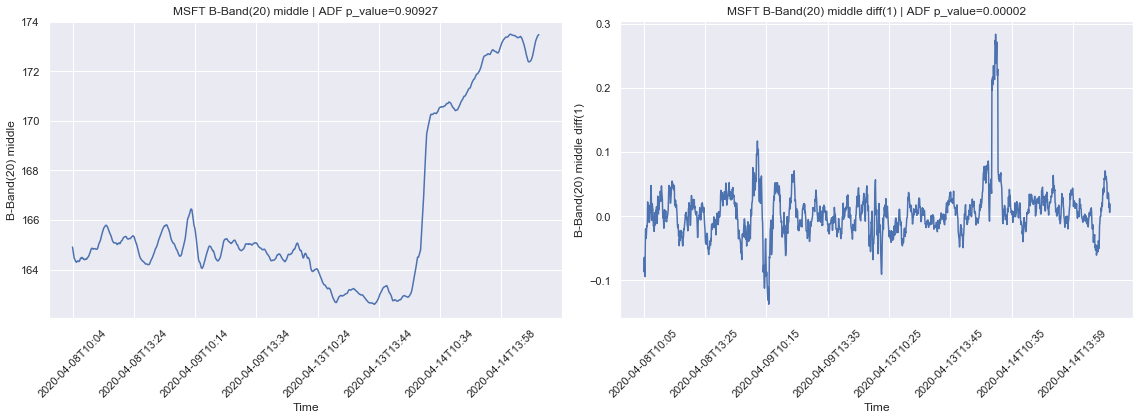

In [33]:
diff_order = 1

plotHelpers.plot_transformed_timeseries_unit(instr,
                        instr.bband20_middle.transform(transforms={'diffs' : {'order' : diff_order}}),
                        'B-Band(20) middle', f'B-Band(20) middle diff({diff_order})',
                        datetime_unit='m', rotation=45)

### [Williams %R](https://www.investopedia.com/terms/w/williamsr.asp)

In [34]:
instr.willr14.adf_report()

(2.755502223055343e-22, True)

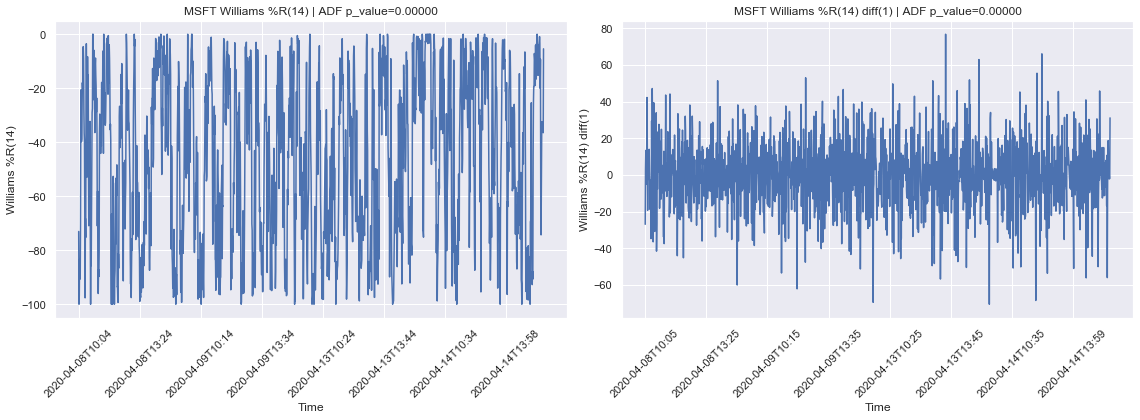

In [35]:
diff_order = 1

plotHelpers.plot_transformed_timeseries_unit(instr,
                        instr.willr14.transform(transforms={'diffs' : {'order' : diff_order}}),
                        'Williams %R(14)', f'Williams %R(14) diff({diff_order})',
                        datetime_unit='m', rotation=45)

### [Stochastic oscillator](https://en.wikipedia.org/wiki/Stochastic_oscillator)

In [36]:
instr.stochd.adf_report()

(3.7300446771833415e-08, True)

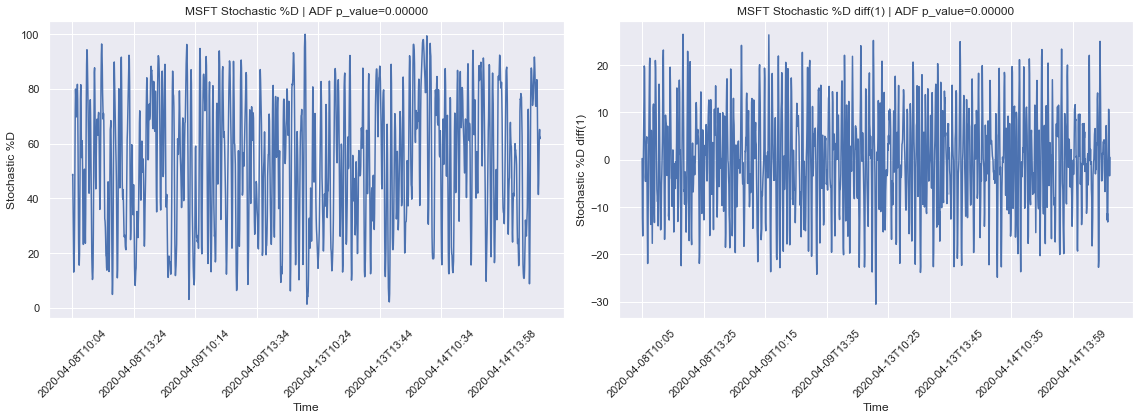

In [37]:
diff_order = 1

plotHelpers.plot_transformed_timeseries_unit(instr,
                        instr.stochd.transform(transforms={'diffs' : {'order' : diff_order}}),
                        'Stochastic %D', f'Stochastic %D diff({diff_order})',
                        datetime_unit='m', rotation=45)

### [Chaikin A/D Line](https://help.haasonline.com/api/examples/pshai-scripts/chaikin-ad-line)

In [38]:
instr.adline.adf_report()

(0.9843464409729881, False)

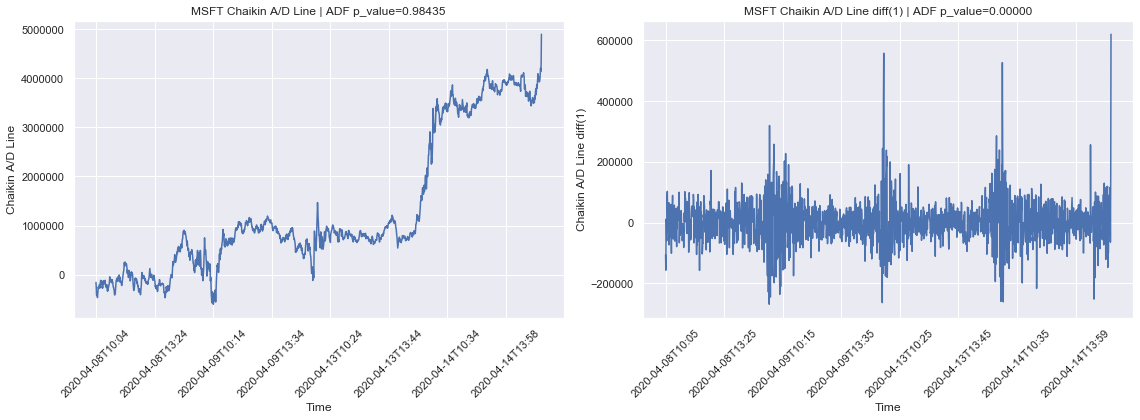

In [39]:
diff_order = 1

plotHelpers.plot_transformed_timeseries_unit(instr,
                        instr.adline.transform(transforms={'diffs' : {'order' : diff_order}}),
                        'Chaikin A/D Line', f'Chaikin A/D Line diff({diff_order})',
                        datetime_unit='m', rotation=45)

### [Chaikin A/D Oscillator](https://www.investopedia.com/terms/c/chaikinoscillator.asp)

In [40]:
instr.adosc.adf_report()

(1.2934661518174552e-21, True)

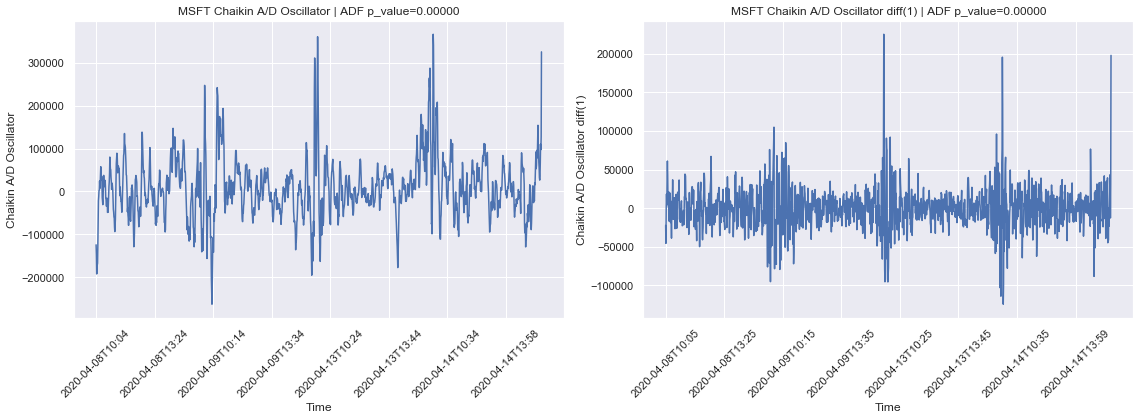

In [41]:
diff_order = 1

plotHelpers.plot_transformed_timeseries_unit(instr,
                        instr.adosc.transform(transforms={'diffs' : {'order' : diff_order}}),
                        'Chaikin A/D Oscillator', f'Chaikin A/D Oscillator diff({diff_order})',
                        datetime_unit='m', rotation=45)

# Трансформированные признаки

Применяем преобразования согласно исследованию, проведённому выше.

In [42]:
def make_feature_selector():
    price_transformer = lambda: {'ratios': {}, 'ln': {}}
    diff_transformer = lambda o: {'diffs': {'order': o}}
    identity_transformer = lambda: {}
    feature_transformations = {
        'o': price_transformer(),
        'h': price_transformer(),
        'l': price_transformer(),
        'c': price_transformer(),
        'v': diff_transformer(1),
        'ema14': diff_transformer(1),
        'ema30': diff_transformer(1),
        'macd': identity_transformer(),
        'macd_signal': identity_transformer(),
        'rsi14': identity_transformer(),
        'bband20_upper': diff_transformer(1),
        'bband20_middle': diff_transformer(1),
        'bband20_lower': diff_transformer(1),
        'willr14': identity_transformer(),
        'stochd': identity_transformer(),
        'stochk': identity_transformer(),
        'adline': diff_transformer(1),
        'adosc': identity_transformer()
    }
    return feature_transformations

Новый контейнер для трансформированных признаков:

In [43]:
instr_transformed = instr.select_transform(make_feature_selector())

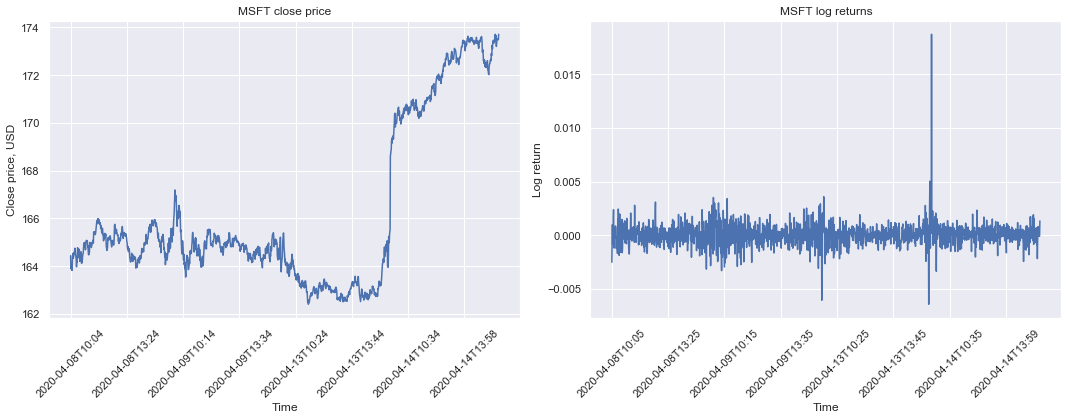

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plotHelpers.plot_timeseries(ax[0], instr.instrument, instr.c,
                            'close price', 'Time', 'Close price, USD',
                            datetime_unit='m', rotation=45)
plotHelpers.plot_timeseries(ax[1], instr_transformed.instrument, instr_transformed.c,
                            'log returns', 'Time', 'Log return',
                            datetime_unit='m', rotation=45)
fig.tight_layout()

# Разделение выборки

На обучение и тест (поскольку у нас данные только за 5 дней, то отдельного сета для валидации не будет)

Так это выглядит для оригинальных данных:

In [45]:
train_unscaled, test_unscaled = instr.train_test_split(VAL_TEST_SPLIT, window_size=WINDOW_SIZE)

# val_unscaled, test_unscaled = val_test_unscaled.train_test_split(TEST_SPLIT, window_size=WINDOW_SIZE)

len(train_unscaled), len(test_unscaled)

(1137, 506)

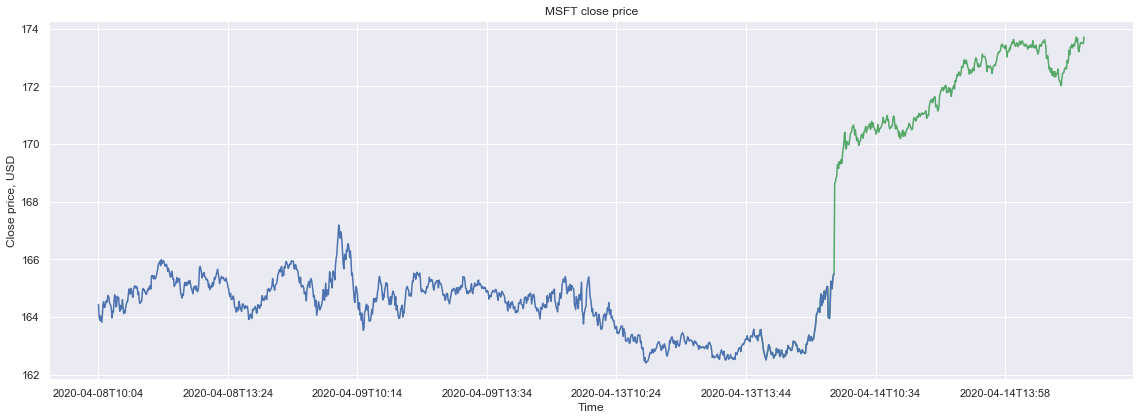

In [46]:
plotHelpers.plot_train_test_split(instr, train_unscaled, test_unscaled, 'c',
                                  WINDOW_SIZE,'close price', 'Time', 'Close price, USD',
                                  datetime_unit='m', rotation=0)
plt.tight_layout()

А так для трансформированных и отмасштабированных данных.

In [47]:
train_scaled, test_scaled = instr_transformed.train_test_split(VAL_TEST_SPLIT, window_size=WINDOW_SIZE,
                                                               scaler=StandardScaler)

# val_scaled, test_scaled = val_test_scaled.train_test_split(TEST_SPLIT, window_size=WINDOW_SIZE, scaler=None)

len(train_scaled), len(test_scaled)

(1136, 506)

**Scaler** настраивается по данным обучающей выборки и потом применяется к валидационной и тестовой.

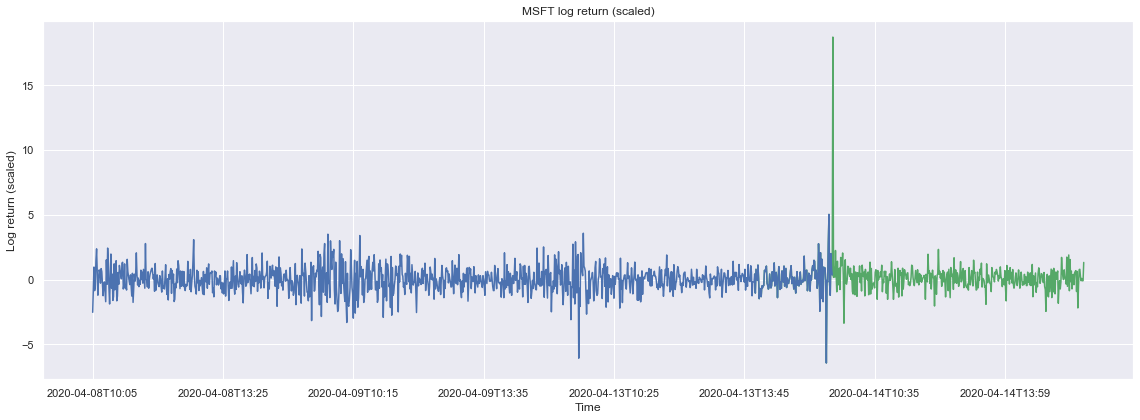

In [48]:
plotHelpers.plot_train_test_split(instr_transformed, train_scaled, test_scaled, 'c',
                                  WINDOW_SIZE,'log return (scaled)', 'Time', 'Log return (scaled)',
                                  datetime_unit='m', rotation=0)
plt.tight_layout()

# Скользящие окна

In [49]:
train_mwf = MovingWindowFeatures.create(train_scaled.c, [train_scaled], train_scaled.feature_names,
                                        WINDOW_SIZE, FORECAST_OFFSET)

train_mwf.features.shape

(1016, 120, 18)

Количество окон заданного размера для одного признака:

In [50]:
train_mwf.get_feature_windows('c').shape

(1016, 120)

Проверим, что данные совпадают для произвольного окна.

In [51]:
assert (train_mwf.get_feature_windows('c')[42] == train_scaled.c.data[42:42 + WINDOW_SIZE]).all()